## Visualizing convnet filters


Another easy thing to do to inspect the filters learned by convnets is to display the visual pattern that each filter is meant to respond 
to. This can be done with __gradient ascent in input space__: applying __gradient descent__ to the value of the input image of a convnet so 
as to maximize the response of a specific filter, starting from a blank input image. The resulting input image would be one that the chosen 
filter is maximally responsive to.

The process is simple: we will build a loss function that maximizes the value of a given filter in a given convolution layer, then we 
will use stochastic gradient descent to adjust the values of the input image so as to maximize this activation value. For instance, here's 
a loss for the activation of filter 0 in the layer "block3_conv1" of the VGG16 network, pre-trained on ImageNet:

### Let's start by defining the VGG16 model in Keras

In [1]:
from keras.applications import vgg16
import numpy as np

# build the VGG16 network with ImageNet weights
base_model = vgg16.VGG16(weights='imagenet', include_top=False)

np.save('base_vgg16.npy', base_model.get_weights())
base_model.save('base_vgg16.h5')

Using TensorFlow backend.


### Load the saved model

In [1]:
from keras.models import load_model
import numpy as np

base_model = load_model('base_vgg16.h5')
base_model.set_weights(np.load('base_vgg16.npy'))

Using TensorFlow backend.
/home/himanshu/tensorflow/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


### Visualizing the model

In [2]:
from IPython.display import display, HTML
from keras.utils import plot_model

def plot_model_architecture(base_model, model_name):
    plot_model(base_model, show_shapes=True, to_file=model_name)
    display(HTML('<img src="{}" style="display:inline;margin:1px"/>'.format(model_name)))

In [3]:
plot_model_architecture(base_model, 'base_vgg16_model.svg')

Note that we only go up to the last convolutional layer --we don't include fully-connected layers. The reason is that adding the fully connected layers forces you to use a fixed input size for the model (224x224, the original ImageNet format). By only keeping the convolutional modules, our model can be adapted to arbitrary input sizes.

### Setting visualization variables

In [2]:
# dimensions of the generated pictures for each filter.
img_width = 128
img_height = 128

# this is the placeholder for the input images
input_img = base_model.input

# get the symbolic outputs of each "key" layer (we gave them unique names).
layer_dict = dict([(layer.name, layer) for layer in base_model.layers[1:]])

# the name of the layer we want to visualize
# (see model definition at keras/applications/vgg16.py)
# layer_name = 'block5_conv1'

### Maximize the activation of a specific filter

We first define some util functions

In [3]:
from keras import backend as K

# util function to convert a tensor into a valid image
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + K.epsilon())
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    if K.image_data_format() == 'channels_first':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

def normalize(x):
    # utility function to normalize a tensor by its L2 norm
    return x / (K.sqrt(K.mean(K.square(x))) + K.epsilon())

Now we can use the Keras function we defined to do gradient ascent in the input space, with regard to our filter activation loss:

In [4]:
def gradient_ascent(iterate):
    # step size for gradient ascent
    step = 1.

    # we start from a gray image with some random noise
    if K.image_data_format() == 'channels_first':
        input_img_data = np.random.random((1, 3, img_width, img_height))
    else:
        input_img_data = np.random.random((1, img_width, img_height, 3))
    input_img_data = (input_img_data - 0.5) * 20 + 128

    # we run gradient ascent for 20 steps
    for i in range(20):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step

#         print('------>Current loss value:', loss_value)
        if loss_value <= 0.:
            # some filters get stuck to 0, we can skip them
            break
        
    # decode the resulting input image
    if loss_value > 0:
        img = deprocess_image(input_img_data[0])
        kept_filters.append((img, loss_value))

We define a loss function that will seek to maximize the activation of a specific filter (filter_index) in a specific layer (layer_name). We do this via a Keras `backend` function called `gradients`, which allows our code to run on top of TensorFlow

The only trick here is to normalize the gradient of the pixels of the input image, which avoids very small and very large gradients and ensures a smooth gradient ascent process.

In [5]:
def build_nth_filter_loss(filter_index, layer_name):
    """
    We build a loss function that maximizes the activation
    of the nth filter of the layer considered
    """
    
    layer_output = layer_dict[layer_name].output
    if K.image_data_format() == 'channels_first':
        loss = K.mean(layer_output[:, filter_index, :, :])
    else:
        loss = K.mean(layer_output[:, :, :, filter_index])
    
    # we compute the gradient of the input picture wrt this loss
    grads = K.gradients(loss, input_img)[0]

    # normalization trick: we normalize the gradient
    grads = normalize(grads)

    # this function returns the loss and grads given the input picture
    iterate = K.function([input_img], [loss, grads])

    return iterate

We need a way to compute the value of the loss tensor and the gradient tensor, given an input image. We define a Keras backend function `iterate` that takes a Numpy tensor (as a list of tensors of size 1) and returns a list of two Numpy tensors: the loss value and the gradient value.

### Understanding how K.gradients() works
Refer: https://www.tensorflow.org/api_docs/python/tf/gradients

In [21]:
# Example of tf.gradients()
import tensorflow as tf

a = tf.constant(0.)
b = 2 * a
g = tf.gradients(a + b, [a, b])

with tf.Session() as sess:
    print(sess.run(g))

[3.0, 1.0]


### Iterating over some number of filters in a given layer_name

In [9]:
layers = ['block1_conv1', 'block1_conv2',
          'block2_conv1', 'block2_conv2',
          'block3_conv1', 'block3_conv2', 'block3_conv3',
          'block4_conv1', 'block4_conv2', 'block4_conv3',
          'block5_conv1', 'block5_conv2', 'block5_conv3']

In [10]:
import time

kept_filters = []
filters_dict = dict()
for layer_name in layers:
    layer = base_model.get_layer(layer_name)
    print('Processing filter for layer:', layer_name)
    for filter_index in range(min(layer.output.shape[-1], 100)):
        # print('Processing filter %d' % filter_index)

        start_time = time.time()
        gradient_ascent(build_nth_filter_loss(filter_index, layer_name))
        end_time = time.time()

#         print('--->Filter %d processed in %ds' % (filter_index, end_time - start_time))
    filters_dict[layer.name] = kept_filters
    kept_filters = []

Processing filter for layer: block1_conv1
Processing filter for layer: block1_conv2
Processing filter for layer: block2_conv1
Processing filter for layer: block2_conv2
Processing filter for layer: block3_conv1
Processing filter for layer: block3_conv2
Processing filter for layer: block3_conv3
Processing filter for layer: block4_conv1
Processing filter for layer: block4_conv2
Processing filter for layer: block4_conv3
Processing filter for layer: block5_conv1
Processing filter for layer: block5_conv2
Processing filter for layer: block5_conv3


In [45]:
for layer_name, kept_filters in filters_dict.items():
    print(layer_name, len(kept_filters))

block1_conv1 58


### Stiching best filters on a black picture

We can start visualising every single filter in every layer. For simplicity, we will only look at the first 64 filters in each layer. We will arrange the outputs on a 8x8 grid of 64x64 filter patterns, with some black margins between each filter pattern.

In [12]:
from keras.preprocessing.image import save_img

def stich_filters(kept_filters, layer_name):
    # By default, we will stich the best 64 (n*n) filters on a 8 x 8 grid.
    n = int(np.sqrt(len(kept_filters)))
    # the filters that have the highest loss are assumed to be better-looking.
    # we will only keep the top 64 filters.
    kept_filters.sort(key=lambda x: x[1], reverse=True)
    kept_filters = kept_filters[:n * n]

    # build a black picture with enough space for
    # our 8 x 8 filters of size 128 x 128, with a 5px margin in between
    margin = 5
    width = n * img_width + (n - 1) * margin
    height = n * img_height + (n - 1) * margin
    stitched_filters = np.zeros((width, height, 3))

    # fill the picture with our saved filters
    for i in range(n):
        for j in range(n):
            img, loss = kept_filters[i * n + j]
            width_margin = (img_width + margin) * i
            height_margin = (img_height + margin) * j
            stitched_filters[
                width_margin: width_margin + img_width,
                height_margin: height_margin + img_height, :] = img

    # save the result to disk
    save_img('stitched_filters_{}.png'.format(layer_name), stitched_filters)
    
for layer_name, kept_filters in filters_dict.items():
    print('Stiching filters for {}'.format(layer_name))
    stich_filters(kept_filters, layer_name)
    print('Completed.')

Stiching filters for block1_conv1
Completed.
Stiching filters for block1_conv2
Completed.
Stiching filters for block2_conv1
Completed.
Stiching filters for block2_conv2
Completed.
Stiching filters for block3_conv1
Completed.
Stiching filters for block3_conv2
Completed.
Stiching filters for block3_conv3
Completed.
Stiching filters for block4_conv1
Completed.
Stiching filters for block4_conv2
Completed.
Stiching filters for block4_conv3
Completed.
Stiching filters for block5_conv1
Completed.
Stiching filters for block5_conv2
Completed.
Stiching filters for block5_conv3
Completed.


Visualizing the filters/kernels of each layer of VGG16 network

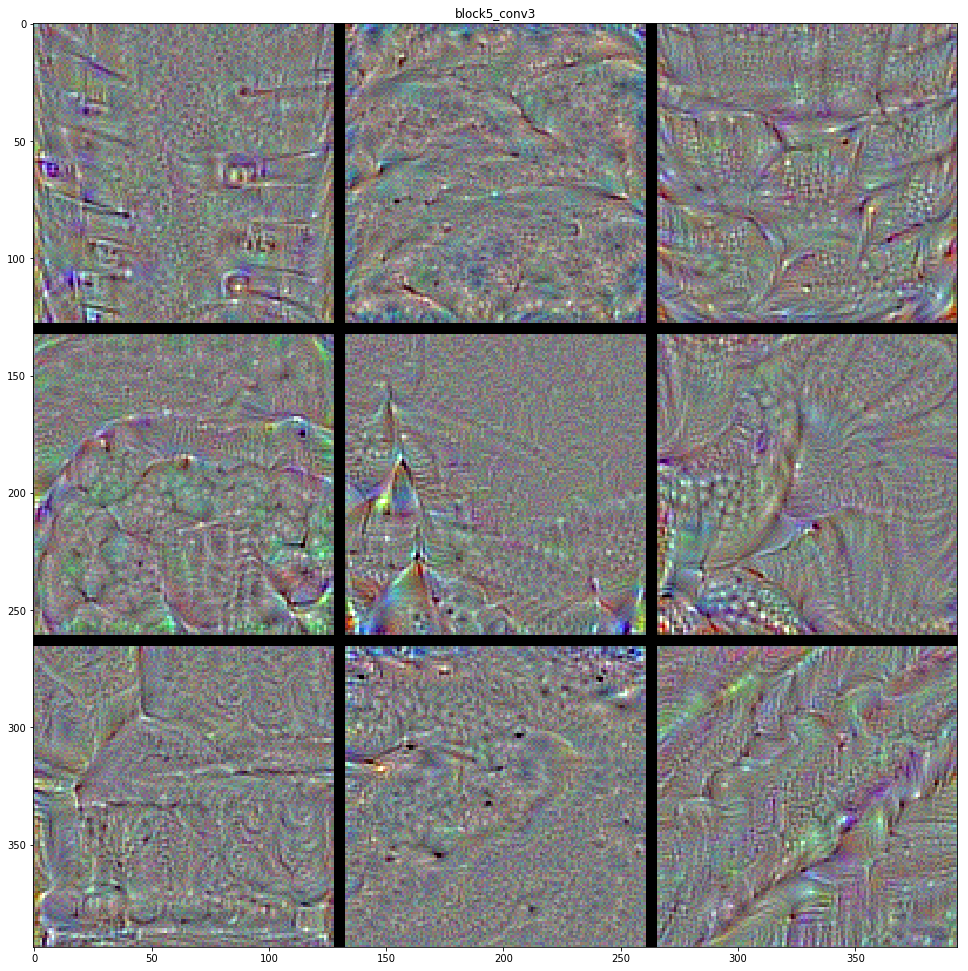

In [13]:
from keras.preprocessing import image
import matplotlib.pyplot as plt
%matplotlib inline

filter_name = 'block5_conv3'

img = image.img_to_array(image.load_img('stitched_filters_{}.png'.format(filter_name))) /255.
plt.figure(figsize=(17,17))
plt.imshow(img)
plt.title(filter_name)
plt.grid(False)

These filter visualizations tell us a lot about how convnet layers see the world: each layer in a convnet simply learns a collection of 
filters such that their inputs can be expressed as a combination of the filters. This is similar to how the Fourier transform decomposes 
signals onto a bank of cosine functions. The filters in these convnet filter banks get increasingly complex and refined as we go higher-up 
in the model:

* The filters from the first layer in the model (`block1_conv1`) encode simple directional edges and colors (or colored edges in some 
cases).
* The filters from `block2_conv1` encode simple textures made from combinations of edges and colors.
* The filters in higher-up layers start resembling textures found in natural images: feathers, eyes, leaves, etc.